# Adding time stamp

In [2]:
import datetime
print(f"This notebook was last run at : {datetime.datetime.now()}")

This notebook was last run at : 2024-06-05 08:15:06.301537


# Checking for GPU configuration in the PC

In [3]:
!nvidia-smi

/bin/bash: line 1: nvidia-smi: command not found


# Downloading the dataset (10% of the food_vision set)

In [4]:
# Get data (10% of labels)
import zipfile

# Download data
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip

# Unzip the downloaded file
zip_ref = zipfile.ZipFile("10_food_classes_10_percent.zip", "r")
zip_ref.extractall()
zip_ref.close()

--2024-06-05 08:15:07--  https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 142.250.31.207, 142.251.111.207, 64.233.180.207, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|142.250.31.207|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 168546183 (161M) [application/zip]
Saving to: ‘10_food_classes_10_percent.zip.2’

10_food_classes_10_ 100%[===================>] 160.74M   131MB/s    in 1.2s    

2024-06-05 08:15:08 (131 MB/s) - ‘10_food_classes_10_percent.zip.2’ saved [168546183/168546183]



# Exploring the folder structure and number of images per folder

In [5]:
# How many images in each folder?
import os

# Walk through 10 percent data directory and list number of files
for dirpath, dirnames, filenames in os.walk("10_food_classes_10_percent"):
  print(f"There are {len(dirnames)} directories and {len(filenames)} images in '{dirpath}'.")

There are 2 directories and 0 images in '10_food_classes_10_percent'.
There are 10 directories and 0 images in '10_food_classes_10_percent/train'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/hamburger'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/fried_rice'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/ramen'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/chicken_wings'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/grilled_salmon'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/pizza'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/sushi'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/ice_cream'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/chicken_curry'.
There are 0 directories and 75 images in '10_food_classes_10_percent

# Preparing the data and loading images into train_data and test_data buffers

In [6]:
# Setup data inputs
from tensorflow.keras.preprocessing.image import ImageDataGenerator

IMAGE_SHAPE = (224, 224)
BATCH_SIZE = 32

train_dir = "10_food_classes_10_percent/train/"
test_dir = "10_food_classes_10_percent/test/"

train_datagen = ImageDataGenerator(rescale=1/255.)
test_datagen = ImageDataGenerator(rescale=1/255.)

print("Training images:")
train_data_10_percent = train_datagen.flow_from_directory(train_dir,
                                               target_size=IMAGE_SHAPE,
                                               batch_size=BATCH_SIZE,
                                               class_mode="categorical")

print("Testing images:")
test_data = train_datagen.flow_from_directory(test_dir,
                                              target_size=IMAGE_SHAPE,
                                              batch_size=BATCH_SIZE,
                                              class_mode="categorical")

Training images:
Found 750 images belonging to 10 classes.
Testing images:
Found 2500 images belonging to 10 classes.


# Creating tensorboard callback

In [7]:
import datetime
def create_tensorboard_callback(dir_name, experiment_name):
  log_dir = dir_name + "/" + experiment_name + "/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
  tensorboard_callback = tf.keras.callbacks.TensorBoard(
      log_dir=log_dir
  )
  print(f"Saving TensorBoard log files to: {log_dir}")
  return tensorboard_callback

# Importing TensorFlow and TensorFlow Hub

In [8]:
import tensorflow as tf
import tensorflow_hub as hub
from tensorflow.keras import layers

# Getting URLs of EfficientNetB0 (2019) and ResNetV250 (2016)

In [9]:
# Resnet 50 V2 feature vector
resnet_url = "https://tfhub.dev/google/imagenet/resnet_v2_50/feature_vector/4"

# Original: EfficientNetB0 feature vector (version 1)
efficientnet_url = "https://tfhub.dev/tensorflow/efficientnet/b0/feature-vector/1"

# # New: EfficientNetB0 feature vector (version 2)
# efficientnet_url = "https://tfhub.dev/google/imagenet/efficientnet_v2_imagenet1k_b0/feature_vector/2"

# Instantiating a Keras Sequential model with the TensorFlow Hub URLs.

In [10]:
def create_model(model_url, num_classes=10):
  """Takes a TensorFlow Hub URL and creates a Keras Sequential model with it.

  Args:
    model_url (str): A TensorFlow Hub feature extraction URL.
    num_classes (int): Number of output neurons in output layer,
      should be equal to number of target classes, default 10.

  Returns:
    An uncompiled Keras Sequential model with model_url as feature
    extractor layer and Dense output layer with num_classes outputs.
  """
  # Download the pretrained model and save it as a Keras layer
  feature_extractor_layer = hub.KerasLayer(model_url,
                                           trainable=False, # freeze the underlying patterns
                                           name='feature_extraction_layer',
                                           input_shape=IMAGE_SHAPE+(3,)) # define the input image shape

  # Create our own model
  model = tf.keras.Sequential([
    feature_extractor_layer, # use the feature extraction layer as the base
    layers.Dense(num_classes, activation='softmax', name='output_layer') # create our own output layer
  ])

  return model

# Creating a model using ResNetV250 architecture as the feature extraction layer and compiling it

In [11]:
# Create model
resnet_model = create_model(resnet_url, num_classes=train_data_10_percent.num_classes)

# Compile
resnet_model.compile(loss='categorical_crossentropy',
                     optimizer=tf.keras.optimizers.Adam(),
                     metrics=['accuracy'])

# Adding callback to record performance of the model

In [12]:
# Fit the model
resnet_history = resnet_model.fit(train_data_10_percent,
                                  epochs=5,
                                  steps_per_epoch=len(train_data_10_percent),
                                  validation_data=test_data,
                                  validation_steps=len(test_data),
                                  # Add TensorBoard callback to model (callbacks parameter takes a list)
                                  callbacks=[create_tensorboard_callback(dir_name="tensorflow_hub", # save experiment logs here
                                                                         experiment_name="resnet50V2")]) # name of log files

Saving TensorBoard log files to: tensorflow_hub/resnet50V2/20240605-081522
Epoch 1/5
24/24 [==============================] - 509s 22s/step - loss: 1.9989 - accuracy: 0.3320 - val_loss: 1.2953 - val_accuracy: 0.6012
Epoch 2/5
24/24 [==============================] - 555s 24s/step - loss: 0.9293 - accuracy: 0.7307 - val_loss: 0.8541 - val_accuracy: 0.7292
Epoch 3/5
24/24 [==============================] - 500s 22s/step - loss: 0.6184 - accuracy: 0.8347 - val_loss: 0.7540 - val_accuracy: 0.7544
Epoch 4/5
24/24 [==============================] - 498s 21s/step - loss: 0.4712 - accuracy: 0.8920 - val_loss: 0.7047 - val_accuracy: 0.7800
Epoch 5/5
24/24 [==============================] - 505s 22s/step - loss: 0.3742 - accuracy: 0.9280 - val_loss: 0.6775 - val_accuracy: 0.7824


# Plotting loss and accuracy functions

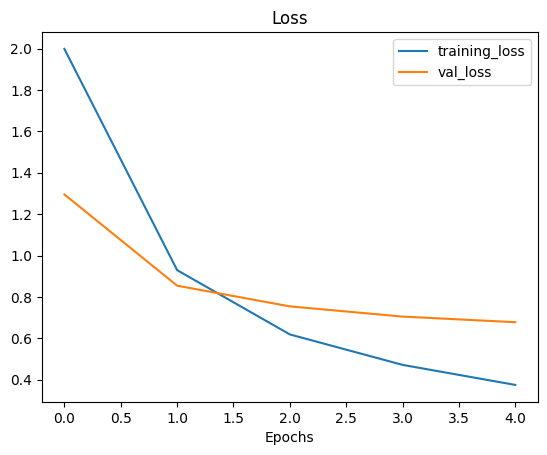

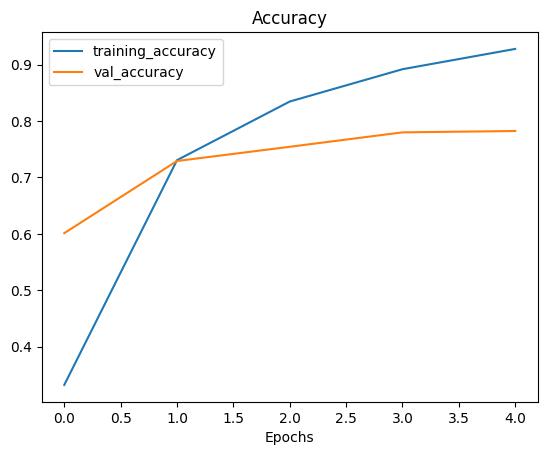

In [13]:
# If you wanted to, you could really turn this into a helper function to load in with a helper.py script...
import matplotlib.pyplot as plt

# Plot the validation and training data separately
def plot_loss_curves(history):
  """
  Returns separate loss curves for training and validation metrics.
  """
  loss = history.history['loss']
  val_loss = history.history['val_loss']

  accuracy = history.history['accuracy']
  val_accuracy = history.history['val_accuracy']

  epochs = range(len(history.history['loss']))

  # Plot loss
  plt.plot(epochs, loss, label='training_loss')
  plt.plot(epochs, val_loss, label='val_loss')
  plt.title('Loss')
  plt.xlabel('Epochs')
  plt.legend()

  # Plot accuracy
  plt.figure()
  plt.plot(epochs, accuracy, label='training_accuracy')
  plt.plot(epochs, val_accuracy, label='val_accuracy')
  plt.title('Accuracy')
  plt.xlabel('Epochs')
  plt.legend();

plot_loss_curves(resnet_history)

# Summary of the model

In [14]:
# Resnet summary
resnet_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 feature_extraction_layer (  (None, 2048)              23564800  
 KerasLayer)                                                     
                                                                 
 output_layer (Dense)        (None, 10)                20490     
                                                                 
Total params: 23585290 (89.97 MB)
Trainable params: 20490 (80.04 KB)
Non-trainable params: 23564800 (89.89 MB)
_________________________________________________________________


# Predicting new image

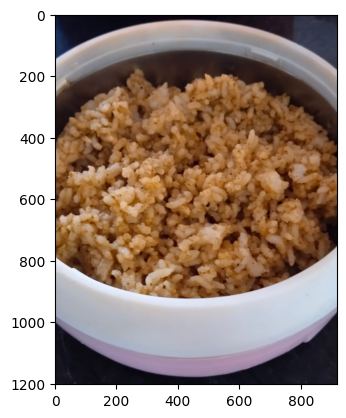

1/1 [==============================] - 0s 151ms/step
[[9.4625331e-04 2.5807301e-04 9.9483490e-01 7.1815004e-05 5.5712994e-06
  1.3811966e-04 2.8476901e-05 3.4750113e-03 6.8344722e-05 1.7341210e-04]]
class_names ['chicken_curry', 'chicken_wings', 'fried_rice', 'grilled_salmon', 'hamburger', 'ice_cream', 'pizza', 'ramen', 'steak', 'sushi']
Predicted class: fried_rice
Indices: [[4 6 8 3 5 9 1 0 7 2]]
fried_rice 99.48 %,  ramen 0.35 %,  chicken_curry 0.09 %


In [71]:
from matplotlib.image import imread
from matplotlib import pyplot as plt

import os
import cv2
import numpy as np

image = imread('/content/friedrice_1_jpgformat.png')
plt.imshow(image)
plt.show()

resized_image = cv2.resize(image, (224, 224))
reshaped = resized_image.reshape(1, 224, 224, 3)

prediction = resnet_model.predict(reshaped)
print(prediction)

#predicted_digit = np.argmax(prediction, axis = 1)
#print("Predicted digit:", predicted_digit[0])

class_names = list(test_data.class_indices.keys()) # Access class names from the ImageDataGenerator
print("class_names", class_names)

# Printing the predicted class for the input food item
print("Predicted class:", class_names[np.argmax(prediction)])

# Identifying indices of top 3 matches
x_list = np.argsort(prediction)[::-1][:3]
print("Indices:", x_list)
x = np.array(x_list)
len_x = 10  # numner of classes

max_1 = x[0][len_x-1]
max_2 = x[0][len_x-2]
max_3 = x[0][len_x-3]

# Printing top three probabilities
print(class_names[max_1], f"{(prediction[0][max_1]*100):.2f}", "%"  ", ", class_names[max_2],
 f"{(prediction[0][max_2]*100):.2f}", "%" ", ", class_names[max_3], f"{(prediction[0][max_3]*100):.2f}", "%")



# Creating a model using EfficientNetB0 architecture, compiling it, fitting it and adding callback

In [16]:
# Create model
efficientnet_model = create_model(model_url=efficientnet_url, # use EfficientNetB0 TensorFlow Hub URL
                                  num_classes=train_data_10_percent.num_classes)

# Compile EfficientNet model
efficientnet_model.compile(loss='categorical_crossentropy',
                           optimizer=tf.keras.optimizers.Adam(),
                           metrics=['accuracy'])

# Fit EfficientNet model
efficientnet_history = efficientnet_model.fit(train_data_10_percent, # only use 10% of training data
                                              epochs=5, # train for 5 epochs
                                              steps_per_epoch=len(train_data_10_percent),
                                              validation_data=test_data,
                                              validation_steps=len(test_data),
                                              callbacks=[create_tensorboard_callback(dir_name="tensorflow_hub",
                                                                                     # Track logs under different experiment name
                                                                                     experiment_name="efficientnetB0")])

Saving TensorBoard log files to: tensorflow_hub/efficientnetB0/20240605-085829
Epoch 1/5
24/24 [==============================] - 242s 10s/step - loss: 1.8328 - accuracy: 0.4347 - val_loss: 1.3189 - val_accuracy: 0.7204
Epoch 2/5
24/24 [==============================] - 254s 11s/step - loss: 1.0665 - accuracy: 0.7747 - val_loss: 0.8800 - val_accuracy: 0.8116
Epoch 3/5
24/24 [==============================] - 256s 11s/step - loss: 0.7549 - accuracy: 0.8387 - val_loss: 0.7043 - val_accuracy: 0.8416
Epoch 4/5
24/24 [==============================] - 222s 10s/step - loss: 0.6040 - accuracy: 0.8733 - val_loss: 0.6151 - val_accuracy: 0.8540
Epoch 5/5
24/24 [==============================] - 228s 10s/step - loss: 0.5122 - accuracy: 0.8973 - val_loss: 0.5581 - val_accuracy: 0.8648


# Plotting loss and accuracy functions

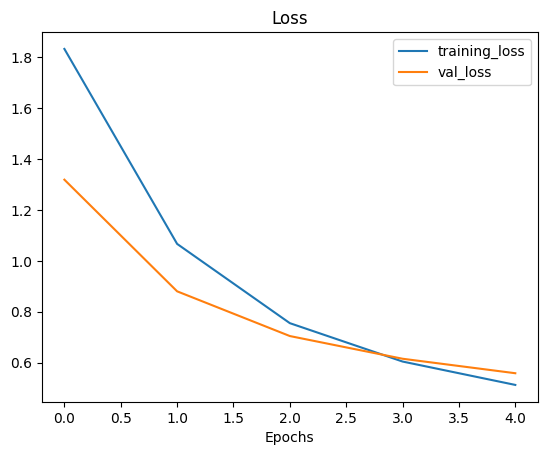

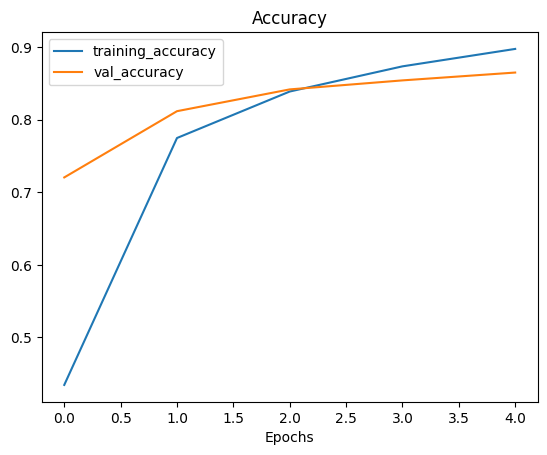

In [17]:
plot_loss_curves(efficientnet_history)

# Model Summary

In [18]:
efficientnet_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 feature_extraction_layer (  (None, 1280)              4049564   
 KerasLayer)                                                     
                                                                 
 output_layer (Dense)        (None, 10)                12810     
                                                                 
Total params: 4062374 (15.50 MB)
Trainable params: 12810 (50.04 KB)
Non-trainable params: 4049564 (15.45 MB)
_________________________________________________________________


# Comparing models

In [19]:
# Upload TensorBoard dev records
!tensorboard dev upload --logdir ./tensorflow_hub/ \
  --name "EfficientNetB0 vs. ResNet50V2" \
  --description "Comparing two different TF Hub feature extraction models architectures using 10% of training images" \
  --one_shot

# Listing experiments saved to TensorBoard
#tensorboard dev list

# Delete an experiment
!tensorboard dev delete --experiment_id n6kd8XZ3Rdy1jSgSLH5WjA

2024-06-05 09:18:34.578294: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-06-05 09:18:34.578386: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-06-05 09:18:34.580200: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-06-05 09:18:36.074498: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
****************************************************************
****************************************************************
****************************************************************

Uploading TensorBoard logs to https://tensorb